<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/w11-t2/tutorials/W11_DeepRL/W11_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 12 Part 2
# Deep Q-Learning

__Instructor:__ Dinesh Jayaraman

__Content creators:__ Byron Galbraith, Chuning Zhu

---

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}
tutorial = 'W12D2'

# start timing
import time
try:t0;
except NameError: t0 = time.time()

---
# Setup

In [ ]:
# imports
import time
from typing import NamedTuple

import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @title Figure Settings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import ipywidgets as widgets

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

In [ ]:
# @title Installing the MinAtar environment

!pip install -q git+https://github.com/kenjyoung/MinAtar

# we do this because sometimes the initial attempt to import the
# environment fails, but then succeeds the 2nd time.
try:
  from minatar.environment import Environment
except:
  from minatar.environment import Environment

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# @title Helper Methods

def epsilon_greedy(n_actions, epsilon):
  def policy_fn(q_net, state):
    if torch.rand(1) < epsilon:
      return torch.randint(n_actions, size=(1,), device=device)
    else:
      with torch.no_grad():
        q_pred = q_net(state)
        return torch.argmax(q_pred).view(1,)
  return policy_fn


def phi(x):
  return torch.from_numpy(x).type(torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)


def simulate(env, agent, max_steps=500): 
    # Simulate the agent for one episode in the environment
    env.reset()
    state = env.state()
    ep_states = [state]
    ep_reward = 0
    term = False
    step = 0
    while (not term) and (step < max_steps):
        action = agent.act(phi(state))
        rew, term = env.act(action)
        state = env.state()
        ep_states.append(state)
        ep_reward += rew
        step += 1
    return ep_states, ep_reward


def plot_minatar_state(state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.tight_layout(pad=0)
        ax.axis('off')
    
    # Plotting configuration
    nc = env.n_channels
    cmap = seaborn.color_palette("cubehelix", nc)
    cmap.insert(0, (0,0,0))
    cmap = colors.ListedColormap(cmap)
    norm = colors.BoundaryNorm([i for i in range(nc+2)], nc+1)
    # Convert state to numerical state and plot with colormap
    numerical_state = np.amax(state*np.reshape(np.arange(nc)+1,(1,1,-1)),2)+0.5
    plot = ax.imshow(numerical_state, cmap=cmap, norm=norm, interpolation='none')
    return plot


def generate_video(states):
    fig, ax = plt.subplots(1, 1)
    fig.tight_layout(pad=0)
    ax.axis('off')

    def frame(i):
        ax.clear()
        state = states[i]
        return plot_minatar_state(state, ax)
    
    anim = animation.FuncAnimation(fig, frame, frames=range(len(states)), 
                                   blit=False, repeat=False, repeat_delay=10000)
    plt.close() # avoid showing extra plots
    return anim


def learn_env(env, agent, gamma, n_steps):
  env.reset()
  state = phi(env.state())

  ep_reward = []
  ep_steps = []
  reward = 0
  t = 0
  tic = time.time()
  for frame in range(n_steps):
    act = agent.act(state)
    rew, term = env.act(act)
    next_state = phi(env.state())
    discount = gamma*(1-term)
  
    agent.train(state, act.unsqueeze(0), rew, discount, next_state, frame)
    reward += rew
    
    if term:
      env.reset()
      state = phi(env.state())
      ep_reward.append(reward)
      reward = 0
      ep_steps.append(t)
      t = 0
    else:
      state = next_state
      t += 1

    if (frame+1) % 10000 == 0:
      toc = time.time()      
      print(f"Frame: {frame+1}, reward: {ep_reward[-1:]}, steps: {ep_steps[-1:]}, time:{toc-tic}")
      tic = toc

  ep_reward.append(reward)  
  ep_steps.append(t)
  return ep_reward, ep_steps

---
# Section 1: From Q-Learning to Deep Q-Learning



Video available at https://youtube.com/watch?v=ECV5yeigZIg


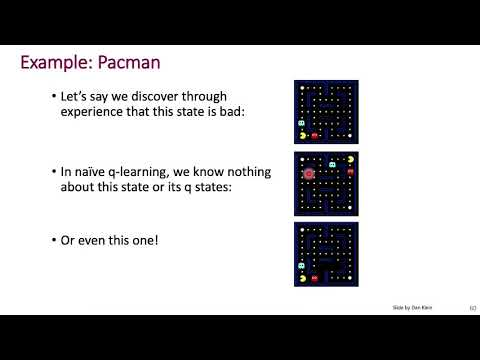

In [ ]:
#@title Video: From Tabular to Deep Q Learning
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ECV5yeigZIg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

In this tutorial, we will study our first "deep" reinforcement learning algorithm: Deep Q-learning. Deep Q-learning is a natural extension of classic Q-learning, which we saw in the last tutorial. Recall that classic Q-learning is a "tabular" method. That is, we keep a table of Q-values for all state and action pairs. What happens if the state space is extremely large or continuous? Well, if the state is represented by a 64x64 image, then the Q table will have $256^{64 * 64} * \text{num_actions}$ entries. This is definitely intractable.

So what do we do? Here's where deep learning comes in to play! We can use a neural network to approximate the Q values. Let's call this neural net Q network. The Q network maps a state and action pair to its Q value. In practice, it takes in a state as input and outputs a vector of Q-values for all actions. We can then create the Q target by taking the max or derive a policy by taking the argmax. Mathematically, let $Q_{\phi}$ be a Q network parametrized by $\phi$. Given a transition tuple, the Q network minimizes the following objective: 

$$\ell(\phi, s, a, r, s') = \left(Q_{\phi}(s, a) - \left(r + \gamma \max_{a'}Q_{\phi}(s', a')\right)\right)^2$$


In other words, we minimize the squared error between the Q estimate and the Q target constructed from the Bellman equation. Convince yourself that an optimal Q network would attain zero loss on all transition tuples. We train the Q network using stochastic gradient descent: 

$$\phi \leftarrow \phi - \alpha \nabla\ell(\phi, s, a, r, s')$$

The "vanilla" DQN algorithm looks very similar to Q-learning: 
```
for n episodes:
    for T steps:
        Forward current state s_t through the Q network to get the Q-values for all actions
        Select an action a_t using epsilon-greedy policy
        Execute a_t in the environment to get reward r and next state s_{t+1}
        Update the Q network by one step of gradient descent
```

In practice, two standard tricks are essential for DQN to work: replay buffer and target network. We will study them in detail. We will also introduce Double DQN, a simple extension that brings significant performance gain. 



Before moving further, let's see the running example for this tutorial. [MinAtar](https://github.com/kenjyoung/MinAtar) is a reduced implemention of five games from the Arcade Learning Environment (ALE). The state of each game is provided as a 10x10xN array, where N is number of relevant game objects. For instance, in the game Breakout, there are four objects - the paddle, where the ball is now, where the ball was last frame, and the remaining blocks. Thus the state for the Breakout environment will have the shape 10x10x4. Each game object only occupies a single element in the cell, as can be seen by running the code below.

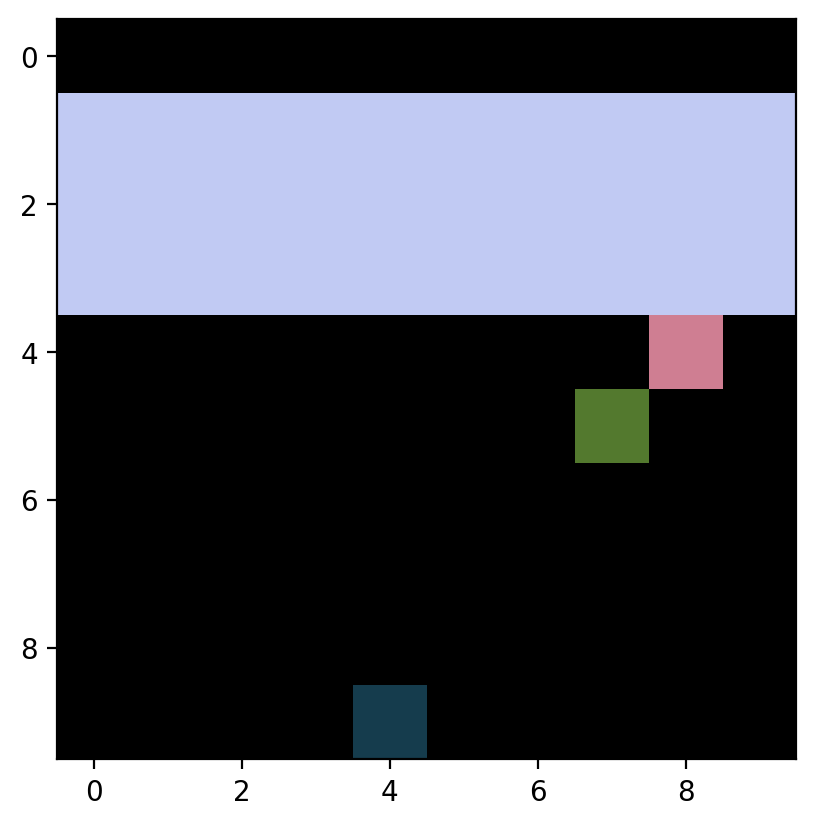

In [ ]:
# crete the Breakout environment
env = Environment('breakout', random_seed=522)
# reset the environment and advance state by two frames to illustrate all channels
env.reset()
env.act(0)
env.act(0)
state = env.state()
fig, ax = plt.subplots()
plot_minatar_state(state, ax)
plt.show()

While this greatly reduces the complexity of the environment, the range of possible states is still large enough to be intractable for tabular methods. We can no longer represent our Q function as a lookup table, so we instead turn to function approximation methods. And, since the MinAtar state is multiple channels arranged in a grid, we can turn to deep learning solutions and our old friend convolutional neural networks.

## Exercise 1: Creating the Q network
In this exercise you will be implementing the forward method of a CNN-based PyTorch module for approximating the Q function of a MinAtar environment. The network needs to take in the state of the environment and produce a value prediction for each possible action. The network itself is given as a 2D convolutional layer followed by two fully connected linear layers with ReLU activation functions on all but the last layer.

Note: You will need to flatten the output of the convolutional layer before passing it to the first linear layer.

In [ ]:
class QNetwork(nn.Module):
  def __init__(self, n_channels, n_actions):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=n_channels, out_channels=16,
                          kernel_size=3, stride=1)
    self.fc1 = nn.Linear(in_features=1024, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=n_actions)

  def forward(self, x):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Q network")
    ####################################################################

    # Pass the input through the convnet layer with ReLU activation
    x = ...
    # Flatten the result while preserving the batch dimension
    x = ...
    # Pass the result through the first linear layer with ReLU activation
    x = ...
    # Finally pass the result through the second linear layer and return
    x = ...
    return x

# Uncomment below to test your module
# env = Environment('breakout', random_seed=522)
# q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
# env.reset()
# state = env.state()
# # note: phi() transforms the state to make it compatible with PyTorch
# q_net(phi(state))

If all went well you should see the Q function output tensor with 6 values, one for each of the 6 actions MinAtar environments allow. Now that you have a working deep neural network approximating your Q function, let's see how well it works on the Breakout task.

First, we are going to define an agent object that is initialized with a policy (always epsilon greedy in these examples), our Q function approximator, and an optimizer for updating our network (always Adam in these examples). On each time step, the `act` method will get called to produce the agent's action given the current state. Once the environment responds to that action, the agent's `train` method gets called with the state, action, reward, discount, next state, and current time step. Just like in the tabular setting, we will start by updating the Q values on every time step.

In [ ]:
class QNetworkAgent:
  def __init__(self, policy, q_net, optimizer):
    self.policy = policy
    self.q_net = q_net
    self.optimizer = optimizer
  
  def act(self, state):
    # we never need to compute gradients on action selection, so we disable
    # autograd to speed up performance
    with torch.no_grad():
      return self.policy(self.q_net, state)
  
  def train(self, state, action, reward, discount, next_state, frame):
    # Compute our predicted q-value given the state and action from our batch
    q_pred = self.q_net(state).gather(1, action)
    # Now compute the q-value target (also called td target or bellman backup)
    # we don't need to compute gradients on the q-value target, just the q-value
    # prediction, so we disable autograd here to speed up performance    
    with torch.no_grad():
      # First get the best q-value from the next state
      q_target = self.q_net(next_state).max(dim=1)[0].view(-1, 1)
      # Next apply the reward and discount to get the q-value target
      q_target = reward + discount * q_target
    # Compute the MSE loss between the predicted and target values
    loss = F.mse_loss(q_pred, q_target)

    # backpropogation to update the q network
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

Now that we have our agent, we are going to have it try to learn the MinAtar Breakout environment. The following code will initialize everything needed to do this, along with your QNetwork module. It will then run the helper function `learn_env` which runs the simulation loop of the agent and environment. `learn_env` will automatically start a new episode whenever the current one terminates and will run for a total of `n_steps` before ending the evaluation. It should take less than 2 minutes to run 50k steps.

*Note:* 50k steps was chosen to be enough to ideally see some real behavior improvement and differences across algorithms while not taking *too* long to train. To achieve a high-performing agent, you would have to train for much longer.


Frame: 10000, reward: [3], steps: [37], time:32.966328859329224
Frame: 20000, reward: [5], steps: [61], time:32.350459575653076
Frame: 30000, reward: [1], steps: [15], time:33.352062463760376
Frame: 40000, reward: [5], steps: [59], time:32.4681556224823
Frame: 50000, reward: [3], steps: [37], time:32.571166038513184


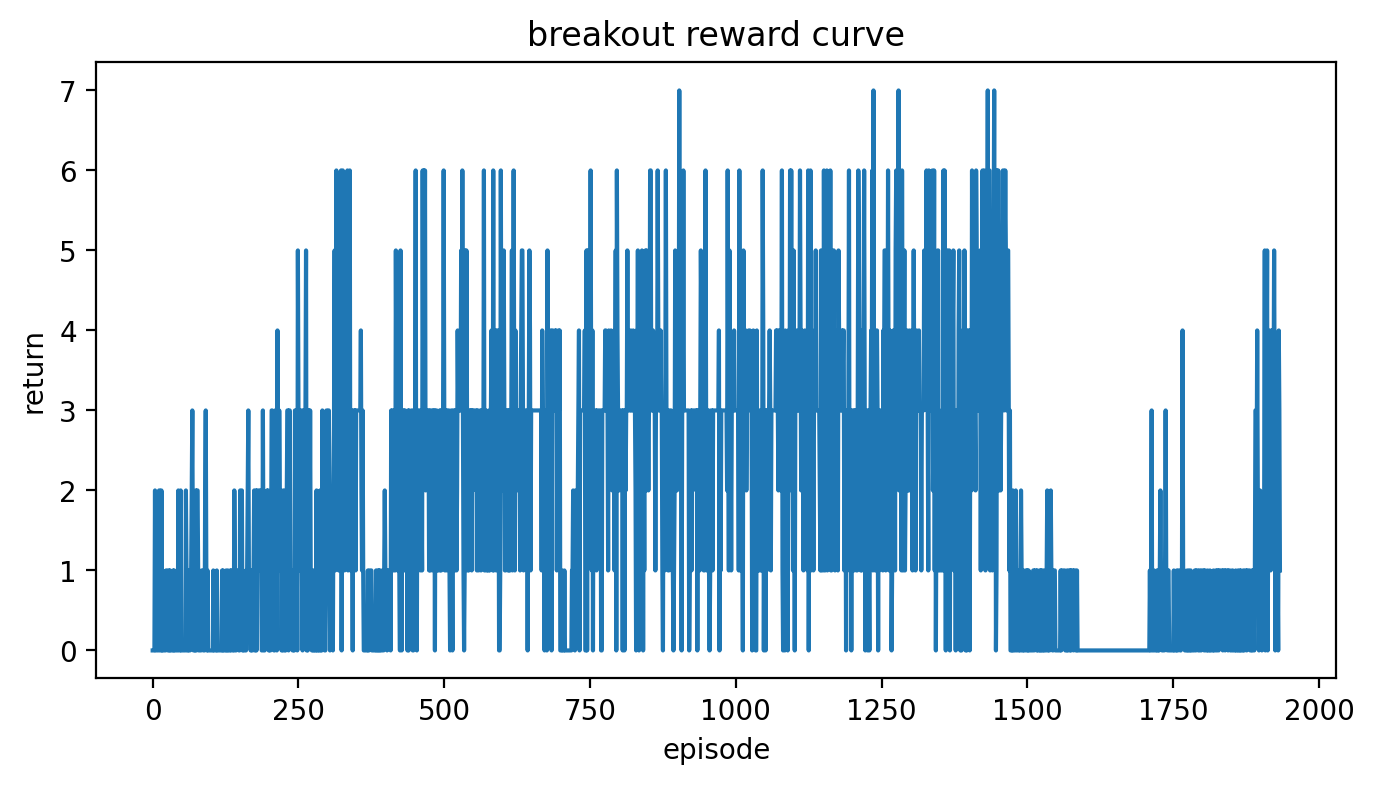

In [ ]:
n_steps = 50000
gamma = 0.99
epsilon = 0.1

env = Environment('breakout')
q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
policy = epsilon_greedy(env.num_actions(), epsilon)
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)
agent = QNetworkAgent(policy, q_net, optimizer)
eps_b_qn = learn_env(env, agent, gamma, n_steps)

plt.figure(figsize=(8, 4))
plt.plot(eps_b_qn[0])
plt.title('breakout reward curve')
plt.xlabel('episode')
plt.ylabel('return')
plt.show()

If your QNetwork module is working properly, you should see the agent starting to get a bit better after a few hundred episodes. We can also visualize how our trained agent is actually playing the game by running the following code.

In [ ]:
# Generate video
ep_states, ep_rew = simulate(env, agent)
generate_video(ep_states)

While this shows some progress on one of tasks in the greatly simplified MinAtar setting, this approach would fare quite poorly on the ALE tasks. The object of the original Deep Q-Network (DQN) paper was to have a general learning solution for all of the games in the ALE. That approach added two key enhancements that enabled this success: using replay buffers and target networks. We will go over each of these in the following sections.

---
# Section 2: Replay Buffer

Video available at https://youtube.com/watch?v=BBBa2mte1Ls


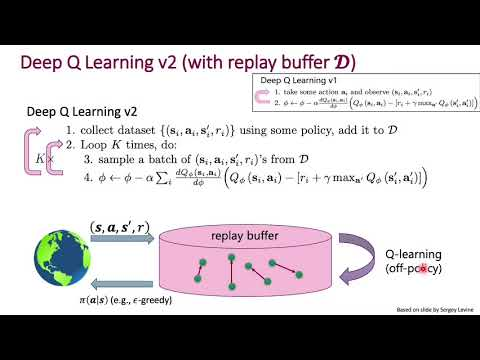

In [ ]:
#@title Video: Experience Replay
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="BBBa2mte1Ls", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Deep learning likes to use SGD w/ mini-batches to speed up training. How do we do this in the RL setting? Replay buffer lets us do that by keeping track of past experience which we can then sample. After each environment interaction, we add the transition tuple $(s, a, r, s')$ to the replay buffer. During training, we randomly sample a mini-batch of transition tuples from the replay buffer and use it to update the Q-network. With a replay buffer, the loss of the Q network becomes

$$\ell(\phi, B) = \frac{1}{|B|}\sum_{(s, a, r, s') \in B}\left(Q_{\phi}(s, a) - \left(r + \gamma \max_{a'}Q_{\phi}(s', a')\right)\right)^2$$

where $B$ is a mini-batch of transition tuples. How large should the replay buffer be? If we use only the most recent data, the Q network will overfit; if we use too much experience, the learning can be very slow. This may take some tuning to get right.

## Creating the replay buffer

In this section, we will implement the sampling part of the replay buffer. Since we want to sample randomly from the buffer, we will use [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html). We are also making use of a `Batch` convenience object to act as a container for the state, action, reward, discount, and next state tensors. This object extends the Python type `NamedTuple` and just allows us to refer to the tensors by name rather than by index (e.g. `batch.state` vs `batch[0]`).

Note that in this implementation we are also storing the discount factor (i.e. $\gamma$) associated with each time step in the replay buffer as well. $\gamma$ is usually fixed so why do this? The answer is that we are actually storing the value $\gamma * (1 - terminal)$ which will be $\gamma$ if the episode is continuing and 0 if it terminated on that step.

In [ ]:
class Batch(NamedTuple):
  state: torch.Tensor
  action: torch.Tensor
  reward: torch.Tensor
  discount: torch.Tensor
  next_state: torch.Tensor

In [ ]:
class ReplayBuffer:
  def __init__(self, state_dim, act_dim, buffer_size):
    self.buffer_size = buffer_size
    self.ptr = 0
    self.n_samples = 0

    self.state = torch.zeros(buffer_size, *state_dim, dtype=torch.float32, device=device)
    self.action = torch.zeros(buffer_size, act_dim, dtype=torch.int64, device=device)
    self.reward = torch.zeros(buffer_size, 1, dtype=torch.float32, device=device)
    self.discount = torch.zeros(buffer_size, 1, dtype=torch.float32, device=device)
    self.next_state = torch.zeros(buffer_size, *state_dim, dtype=torch.float32, device=device)

  def add(self, state, action, reward, discount, next_state):
    self.state[self.ptr] = state
    self.action[self.ptr] = action
    self.reward[self.ptr] = reward
    self.discount[self.ptr] = discount
    self.next_state[self.ptr] = next_state
    
    if self.n_samples < self.buffer_size:
      self.n_samples += 1

    self.ptr = (self.ptr + 1) % self.buffer_size

  def sample(self, batch_size):      
    # Select batch_size number of sample indicies at random from the buffer
    idx = np.random.choice(self.n_samples, batch_size)    
    # Using the random indices, assign the corresponding state, action, reward,
    # discount, and next state samples.
    state = self.state[idx]
    action = self.action[idx]
    reward = self.reward[idx]
    discount = self.discount[idx]
    next_state = self.next_state[idx]
    
    return Batch(state, action, reward, discount, next_state)

If all went well, you should see the following, a (2x1x2x2) tensor representing a batch of state values:
```
tensor([[[[0.5818, 0.7804],
          [0.3947, 0.7742]]],


        [[[0.5818, 0.7804],
          [0.3947, 0.7742]]]], device='cuda:0')
```

---
# Section 3: Target Network



Video available at https://youtube.com/watch?v=RaIcFiNqP-0


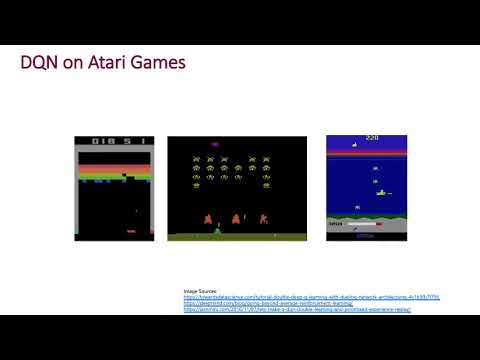

In [ ]:
#@title Video: Target Networks
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="RaIcFiNqP-0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Observe that the Q target is computed using the current Q estimates. Since we update the Q estimates in each training step, we are essentially trying to hit a moving target. This could be mitigated by introducing a target network. Target network is a copy of the Q-network that we update slowly to provide some stability for training. Formally, the Q network loss becomes $$\ell(\phi, B) = \frac{1}{|B|}\sum_{(s, a, r, s') \in B}\left(Q_{\phi}(s, a) - \left(r + \gamma \max_{a'}Q_{\phi_{\text{targ}}}(s', a')\right)\right)^2$$

There are two ways to maintain the target network. One option is to freeze and hard update (full swap) with some training interval. This was the approach used in the original DQN paper. Another way is to use a soft update (polyak averaging), which updates the target every time step with a small weighted average. This was introduced later in the Deep Deterministic Policy Gradient (DDPG) paper to improve training stability, and is the approach we use here.

The following cell defines a soft update function that we will use in section 2.

In [ ]:
def soft_update_from_to(source, target, tau):
  for target_param, param in zip(target.parameters(), source.parameters()):
    target_param.data.copy_(
      target_param.data * (1.0 - tau) + param.data * tau
  )

## Exercise 2: Putting everything together

In this exercise you will adapt the previous QNetworkAgent to take advantage of both the replay buffer for generating batches of samples to train on and the target network for improving training stability. In particular you will focus on implementing most of the `train` method. Feel free to refer back to the original QNetworkAgent `train` method for hints on how to proceed. The [torch.gather](https://pytorch.org/docs/stable/generated/torch.gather.html) method will be useful for selecting action indices across a batch.

The two key changes you will be making from the previous agent are 1) using batches from the replay buffer for training instead of just the direct input and 2) incorporating the target network into the loss function calculation. Recall that the replay buffer returns a `Batch` object, which has state, action, reward, discount, and next_state properties.

There are also other changes to the agent's logic related to the replay buffer. The agent now has a parameter for when it should start training. If the time step hasn't reached that point, the agent just takes a random action and stores the value in the buffer but doesn't update the q or target networks.

In [ ]:
class DQNAgent:
  def __init__(self, policy, q_net, target_net, optimizer, tau, replay_buffer,
               batch_size, train_start):
    self.policy = policy
    self.q_net = q_net
    self.target_net = target_net
    # we never need to compute gradients on the target network, so we disable
    # autograd to speed up performance
    for p in self.target_net.parameters():
      p.requires_grad = False
    self.optimizer = optimizer
    self.tau = tau
    self.replay_buffer = replay_buffer
    self.batch_size = batch_size
    self.train_start = train_start
    self.is_waiting = True
    
  def act(self, state):
    # we never need to compute gradients on action selection, so we disable
    # autograd to speed up performance
    with torch.no_grad():
      if self.is_waiting:
        return torch.randint(6, (1,1))
      return self.policy(self.q_net, state)
  
  def train(self, state, action, reward, discount, next_state, frame):
    # Add the step to our replay buffer
    replay_buffer.add(state, action, reward, discount, next_state)  
    # Don't train if we aren't ready
    if frame < self.train_start:
      return
    elif frame == self.train_start:
      self.is_waiting = False

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("DQN train")
    ####################################################################

    # Using the Replay Buffer, sample a batch of steps for training
    batch = ...

    # First let's compute our predicted q-values
    # We need to pass our batch of states (batch.state) to our q_net    
    q_actions = ...
    # Then we select the q-values that correspond to the actions in our batch
    # (batch.action) to get our predictions (hint: use the gather method)
    q_pred = ...
    
    # Now compute the q-value target (also known as the td target or bellman
    # backup) using our target network. Since we don't need gradients for this,
    # we disable autograd here to speed up performance    
    with torch.no_grad():
      # First get the q-values from our target_net using the batch of next
      # states.
      q_target_actions = ...
      # Get the values that correspond to the best action by taking the max along
      # the value dimension (dim=1)
      q_target = q_target_actions.max(dim=1)[0].view(-1, 1)
      # Next multiply q_target by batch.discount and add batch.reward
      q_target = ...
    # Compute the MSE loss between the predicted and target values, then average
    # over the batch
    loss = ...

    # backpropogation to update the q-network
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # soft update target network with the updated q-network
    soft_update_from_to(self.q_net, self.target_net, self.tau)


Now that we have our DQN agent, let's set everything up and see how well it learns the Breakout environment. While doing initial testing, set `n_steps` to 10k and ensure eveything appears to be running. Once it looks good, set `n_steps` to 50k, which should run in around 2 minutes or so.

In [ ]:
n_steps = 50000
gamma = 0.99
epsilon = 0.1
tau = 1e-2  # how slowly we update the target network 

env = Environment('breakout', random_seed=522)
state_dim = (env.n_channels, 10, 10)
act_dim = 1
buffer_size = 100000
batch_size = 64
train_start = 5000

q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
target_net = QNetwork(env.n_channels, env.num_actions()).to(device)
policy = epsilon_greedy(env.num_actions(), epsilon)
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(state_dim, act_dim, buffer_size)
agent = DQNAgent(policy, q_net, target_net, optimizer, tau, replay_buffer,
                 batch_size, train_start)
eps_b_dqn = learn_env(env, agent, gamma, n_steps)

Frame: 10000, reward: [2], steps: [27], time:24.841342449188232
Frame: 20000, reward: [3], steps: [37], time:47.47797441482544
Frame: 30000, reward: [7], steps: [81], time:46.86301803588867
Frame: 40000, reward: [8], steps: [93], time:47.41810488700867
Frame: 50000, reward: [9], steps: [103], time:47.01058483123779


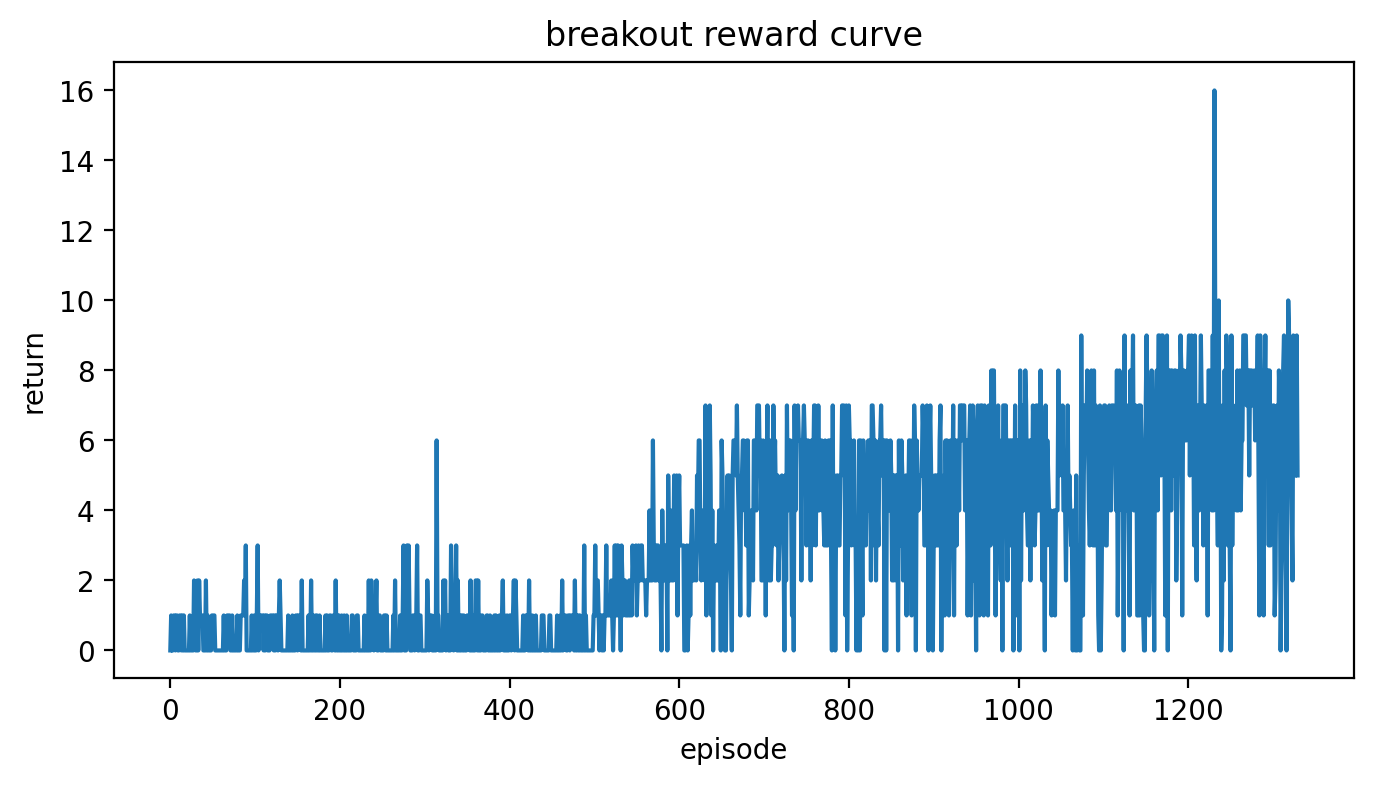

In [ ]:
#@markdown Run cell to plot reward curve
plt.figure(figsize=(8, 4))
plt.plot(eps_b_dqn[0])
plt.title('breakout reward curve')
plt.xlabel('episode')
plt.ylabel('return')
plt.show()

In [ ]:
#@markdown Run cell to generate video
ep_states, ep_rew = simulate(env, agent)
generate_video(ep_states)

You should see more consistent and stable returns over time with the DQNAgent vs the QNetworkAgent. Except for the beginning where the agent doesn't really learn much until around 500 episodes or so, which is related to that `train_start` parameter.

---
# Section 4: Double Q-Learning





Video available at https://youtube.com/watch?v=Lb5ADHnRQV8


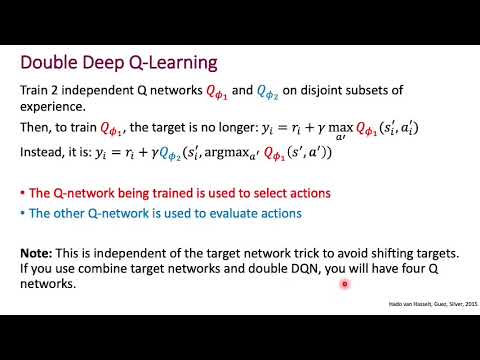

In [ ]:
#@title Video: Double DQN
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Lb5ADHnRQV8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

A problem with DQN is that the max operator on the target network can result in overestimated values because we are mixing the selection and evaluation of actions in the same network. Double DQN decouples them by making the action selection and evaluation based on two Q-networks updated in parallel: 

\begin{align*}
Q_{\phi_1} (s, a) &\leftarrow r + \gamma Q_{\phi_2}\left(s', \arg\max_{a'} Q_{\phi_1}(s', a')\right) \\
Q_{\phi_2} (s, a) &\leftarrow r + \gamma Q_{\phi_1}\left(s', \arg\max_{a'} Q_{\phi_2}(s', a')\right)
\end{align*}

If we apply double DQN on top of the target network trick, then in theory, we would have 4 networks: two Q networks and two target Q networks. In practice, however, we can simply use the target network as the second Q network. Since the target network is updated with a lag, it can be used as the second Q network to decouple action selection and evaluation, thus mitigating the overestimation issue. This boils down to a very simple change to the target DQN loss:

$$\ell(\phi, B) = \frac{1}{|B|}\sum_{(s, a, r, s') \in B}\left(Q_{\phi}(s, a) - \left(r + \gamma Q_{\phi_{\text{targ}}}\left(s', \arg\max_{a'}Q_{\phi}(s', a')\right)\right)\right)^2$$


## Exercise 3: Double DQN

In the following exercise, you will create the training method for the DoubleDQN agent. Since we are only updating the `train` from the original DQNAgent, you will work from a subclass of that agent. This is a helpful design pattern if you want to only change one part of an existing agent while keeping the rest of its behavior intact. In the case of DoubleDQN, you are only changing how the target Q value is determined.



In [ ]:
class DoubleDQNAgent(DQNAgent):
  def train(self, state, action, reward, discount, next_state, frame):
    # Add the step to our replay buffer
    replay_buffer.add(state, action, reward, discount, next_state)  
    # Don't train if we aren't ready
    if frame < self.train_start:
      return
    elif frame == self.train_start:
      self.is_waiting = False
    
    # Sample a batch of steps for training
    batch = self.replay_buffer.sample(self.batch_size)
    
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Double DQN")
    ####################################################################
    
    # First let's compute our predicted q-values
    # We need to pass our batch of states (batch.state) to our q_net    
    q_actions = self.q_net(batch.state)
    # Then we select the q-values that correspond to the actions in our batch
    # (batch.action) to get our predictions
    q_pred = q_actions.gather(1, batch.action)

    # Now compute the q-value target (also known as the td target or bellman
    # backup) using our target network. Since we don't need gradients for this,
    # we disable autograd here to speed up performance
    with torch.no_grad():
      # Compute the action values from our q_net using a batch.next_state
      q_next_actions = ...
      # Use this to find the actions that correspond to the largest values
      # (i.e. argmax)
      max_acts = ...
      # Next get the action values using our target_net and batch.next_state
      q_target_actions = ...
      # Then we select the q-values that correspond to the actions we just found
      # (hint: use the gather method)
      q_target = ...
      # Next multiply q_target by batch.discount and add batch.reward
      q_target = ...
    
    # Compute the MSE loss between the predicted and target values, then average
    # over the batch
    loss = ...

    # backpropogation to update the q network
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # soft update target network with the updated q-network
    soft_update_from_to(self.q_net, self.target_net, self.tau)

Now that we have our DoubleDQNAgent, let's see how it fares on the Breakout envionment. Again, set `n_steps` to something small but larger than the `train_start` value (e.g. 10k) to ensure everything is running smoothly. Once satisfied, set `n_steps` to 50k steps and run, which should take around 2.5 minutes.

In [ ]:
n_steps = 50000
gamma = 0.99
epsilon = 0.1
tau = 1e-2

env = Environment('breakout', random_seed=522)
state_dim = (env.n_channels, 10, 10)
act_dim = 1
buffer_size = 100000
batch_size = 64
train_start = 5000

q_net = QNetwork(env.n_channels, env.num_actions()).to(device)
target_net = QNetwork(env.n_channels, env.num_actions()).to(device)
policy = epsilon_greedy(env.num_actions(), epsilon)
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(state_dim, act_dim, buffer_size)

agent = DoubleDQNAgent(policy, q_net, target_net, optimizer, tau, replay_buffer,
                       batch_size, train_start)
eps_b_ddqn = learn_env(env, agent, gamma, n_steps)

Frame: 10000, reward: [2], steps: [27], time:33.693790674209595
Frame: 20000, reward: [5], steps: [61], time:51.68562889099121
Frame: 30000, reward: [8], steps: [93], time:53.18132829666138
Frame: 40000, reward: [4], steps: [49], time:52.90291357040405
Frame: 50000, reward: [2], steps: [25], time:52.45613098144531


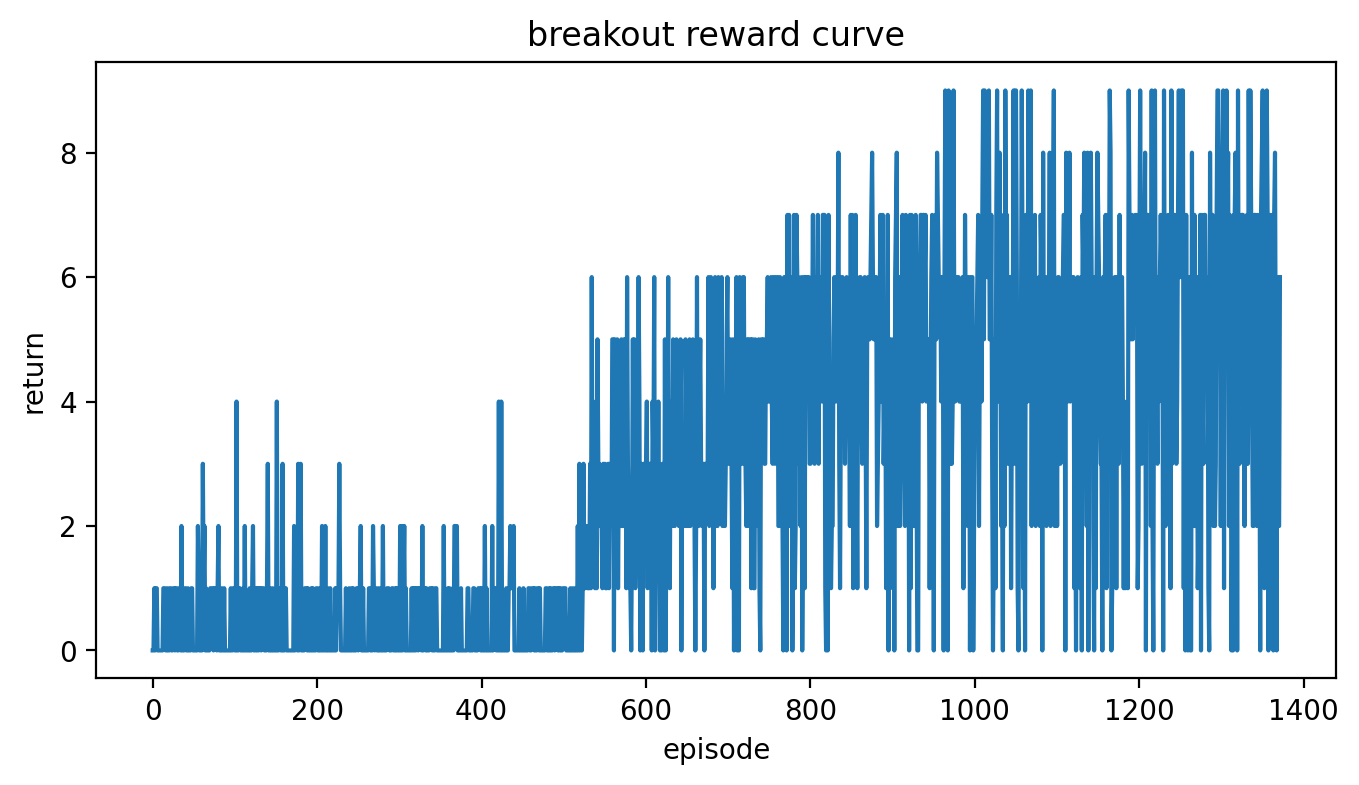

In [ ]:
#@markdown Run cell to plot reward curve
plt.figure(figsize=(8, 4))
plt.plot(eps_b_ddqn[0])
plt.title('breakout reward curve')
plt.xlabel('episode')
plt.ylabel('return')
plt.show()

In [ ]:
#@markdown Run cell to generate video
ep_states, ep_rew = simulate(env, agent)
generate_video(ep_states)

We should see similar performance initially to that of the DQNAgent, but a jump in some of the high scores after around 1000 episodes and a slightly better average result within the first 50k steps. You may have noticed however that this came at a performance hit in terms of training speed over the DQNAgent, which in turn was slower to train than the QNetworkAgent.

---
# Section 5: Extending to Continuous Actions



Video available at https://youtube.com/watch?v=ljHwbY9QrJU


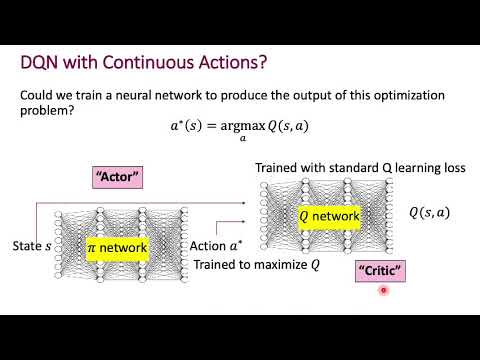

In [ ]:
#@title Video: Deep Deterministic Policy Gradients
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ljHwbY9QrJU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

So far, we've seen a few successes of DQN on the MinAtar environment. Can we use DQN to solve all RL problems? Unfortunately, one glaring assumption of DQN is discrete actions. When computing the Q target or deriving the greedy policy, we need to take the argmax of Q-values over actions. If the action space is continuous, then searching for the argmax is a nontrivial optimization problem. Since we need to perform this search in each step of training and inference, the computation time becomes intractable.

[Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971) extends DQN to continuous actions by introducing an actor network. The goal of the actor network is to predict the action that maximizes the Q-value given the current state. This effectively amortizes the argmax search into training. Concretely, let $\mu_{\theta}$ be an actor network paramterized by $\theta$. The actor's objective is to output an action that maximizes its Q-value: $$\max_{\theta} E_{s \sim D}\left[Q_{\phi}(s, \mu_{\theta}(s))\right]$$ and the Q network's loss becomes $$L(\phi, D) = E_{(s, a, r, s') \sim D}\left[\left(Q_\phi(s, a) - (r + \gamma Q(s', \mu_{\theta}(s'))\right)^2\right] $$ where we have replaced $\max_{a'}Q(s', a')$ with $Q(s', \mu_\theta(s'))$. During training, we optimize the actor network and the Q network jointly using gradient descent.

You may have noticed that the actor network looks like a policy. Indeed, DDPG is belongs to a family of RL algorithms called actor-critic algorithms. An actor-critic algorithm typically consists of a policy and a value function that are jointly optimized. The value function guides policy learning, and inference is done with the policy alone. We will discuss policy optimization and actor-critic algorithms in greater detail next week. 


---
# Wrap-up and Feedback forms

In [1]:
#@markdown #Run Cell to Show Airtable Form
#@markdown Confirm your answers and then click "Submit". If you're having any issues, fill out the form here: https://airtable.com/shrLAYs1VnV04NatF.

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

# autofill fields if they are not present
# a missing pennkey and pod will result in an Airtable warning
# which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: my_email;
except NameError: my_email = ""




times = np.array([t1])-t0

fields = {
    "pennkey": my_pennkey,
    "pod": my_pod, 
    "email": my_email, 
    "cumulative_times": times
}

src = "https://airtable.com/embed/shrLAYs1VnV04NatF?"

display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shr1TzujOOOY21kFQ">https://airtable.com/shr1TzujOOOY21kFQ</a>

In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))